# Project 1

Mama mia, here we go again (with classification)...

## Imports 

In [1]:
import sys

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

print(f"Python version: {sys.version}.")

Python version: 3.10.4 (main, Mar 31 2022, 03:38:35) [Clang 12.0.0 ].


## Loading Data

In [2]:
df_train = pd.read_csv("./Data_train.csv")

In [3]:
df_train.head()

,Unnamed: 0,x,y,class
0,0,9.478938,-4.950071,1
1,1,-8.476344,3.635107,3
2,2,4.080771,-3.684994,3
3,3,-0.509729,-5.700655,2
4,4,-0.898476,-4.007790,3


In [4]:
df_train = df_train.drop("Unnamed: 0", axis='columns')
df_train.head()

,x,y,class
0,9.478938,-4.950071,1
1,-8.476344,3.635107,3
2,4.080771,-3.684994,3
3,-0.509729,-5.700655,2
4,-0.898476,-4.007790,3


In [45]:
X_train, y_train = df_train[["x", "y"]].values, df_train["class"].values

In [48]:
y_train.shape

(5625,)

Let's do the same for the test data:

In [7]:
df_test = pd.read_csv("./Data_test.csv").drop("Unnamed: 0", axis='columns')
df_test.head()

,x,y,class
0,2.597513,-1.720239,1
1,7.951270,6.252087,2
2,-6.913355,4.858647,3
3,-2.948122,-0.585784,3
4,0.865727,-3.874243,3


In [49]:
X_test, y_test = df_test[["x", "y"]].values, df_test["class"].values

## Task 0: Naive Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

Let's scale our data to be Gaussian:

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

And let's also do a quick visualization to verify we have nonlinear data:

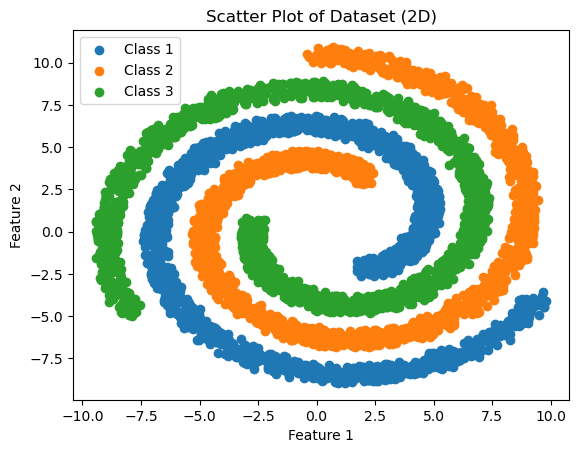

In [52]:
class1, class2, class3 = (
    df_train[df_train["class"] == 1][["x", "y"]],
    df_train[df_train["class"] == 2][["x", "y"]],
    df_train[df_train["class"] == 3][["x", "y"]],
)

plt.scatter(class1["x"], class1["y"], label='Class 1')
plt.scatter(class2["x"], class2["y"], label='Class 2')
plt.scatter(class3["x"], class3["y"], label='Class 3')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Dataset (2D)")
plt.legend()
plt.show()

Intriguing!
Okay, so by this plot we need to make sure our model can handle multinomial problems. The args I'm passing below are the defaults, but I just to be explicit about the type of model being created (and further description can be found on the `sklearn` [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

In [67]:
def evaluate_log_reg(X_train, y_train, X_test,
                    y_test, kernel_type=''):
    model = LogisticRegression(solver='lbfgs', multi_class='multinomial')
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"{kernel_type} Logisitic Regression Accuracy: {round(accuracy * 100, 4)}%.")
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.show()

Naive Logisitic Regression Accuracy: 34.7733%.


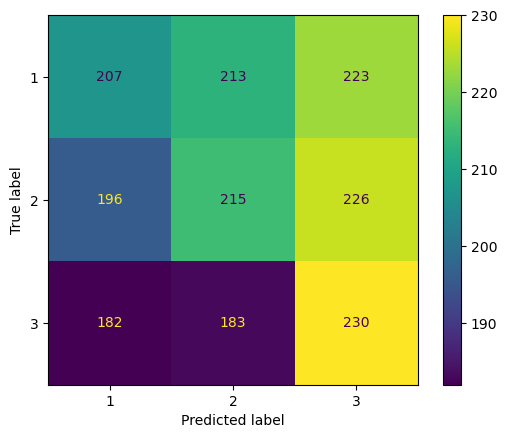

In [68]:
evaluate_log_reg(X_train_scaled, y_train,
                X_test_scaled, y_test, kernel_type='Naive')

Accuracy is only ~34% (not great).

## Task 1: Train Data Transformation

### Kernel 1: Quadratic

**Justification**:
- it is straightforward enough to implement, which makes it a good pick for our first kernel.

**Mathematical Expansion**:

 $$k(x,y)=<x,y>^2=<x^2,\sqrt{2}xy,y^2>$$

Now let's take a crack at doing this in the code:

In [69]:
def quadratic_feature_mapping(x, y):
    """Assume both x and y are column vectors of shape (n, 1)."""
    x_1d = np.squeeze(x)
    y_1d = np.squeeze(y)

    feat1 = x_1d ** 2
    feat2 = np.sqrt(2) * x_1d * y_1d
    feat3 = y_1d ** 2
   			
    return np.column_stack([feat1, feat2, feat3])

In [70]:
quadratic_X_train = quadratic_feature_mapping(
    # x and y are passed here as args, respectively
    X_train_scaled[:, 0], X_train_scaled[:, 1],
)

quadratic_X_test = quadratic_feature_mapping(
    X_test_scaled[:, 0], X_test_scaled[:, 1],  # x & y, respectively
)

Well! We've transformed the data, but how do we know whether or not this will lead to a better logistic regression model?

Let's go ahead and valid the 4 assumption of linear classifiers:

#### Assumption 1: Linear Relationship Between Each Feature with the Target

To verify this, let's make a new scatter plot between each feature and the target column.
We'll start by doing this on the input dataset, so we have a bit of a baseline:

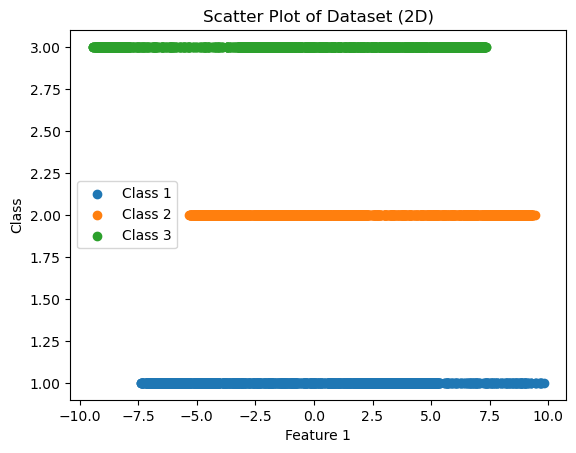

In [78]:
class1, class2, class3 = (
    df_train[df_train["class"] == 1],
    df_train[df_train["class"] == 2],
    df_train[df_train["class"] == 3],
)

plt.scatter(class1["x"], class1["class"], label='Class 1')
plt.scatter(class2["x"], class2["class"], label='Class 2')
plt.scatter(class3["x"], class3["class"], label='Class 3')
plt.xlabel("Feature 1")
plt.ylabel("Class")
plt.title("Scatter Plot of Dataset (2D)")
plt.legend()
plt.show()

And now for the other feature, `y`:

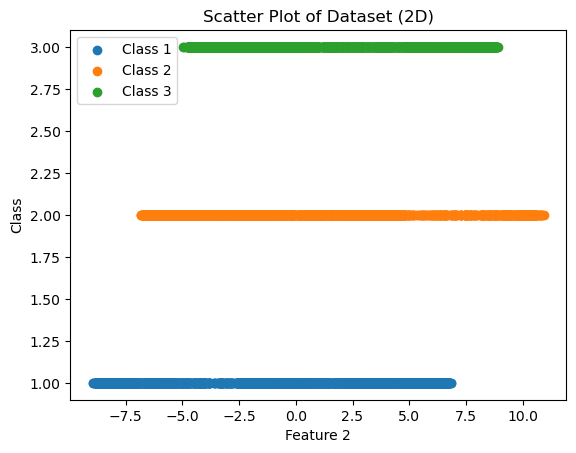

In [80]:
class1, class2, class3 = (
    df_train[df_train["class"] == 1],
    df_train[df_train["class"] == 2],
    df_train[df_train["class"] == 3],
)

plt.scatter(class1["y"], class1["class"], label='Class 1')
plt.scatter(class2["y"], class2["class"], label='Class 2')
plt.scatter(class3["y"], class3["class"], label='Class 3')
plt.xlabel("Feature 2")
plt.ylabel("Class")
plt.title("Scatter Plot of Dataset (2D)")
plt.legend()
plt.show()

**Conclusion**: as we can see, both `X` and `Y` individually have a linear relationship with the target `class` column. This means that the input dataset at least meets the first assumption for multiple linear classfication.

#### Assumption 2: Independence

As you know, this assumption is about making sure that different observations in our dataset are independent from each other. I think it is safe to say it is indeed true for our dataset, as it appears that we are not working with time series data.

#### Assumption 3: 

## SCRAP
Ignore everthing below.

Quadratic Kernel Logisitic Regression Accuracy: 36.6933%.


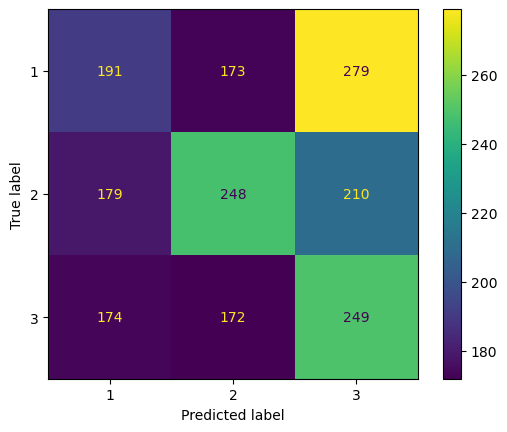

In [73]:
evaluate_log_reg(quadratic_X_train, y_train,
                quadratic_X_test, y_test,
                kernel_type='Quadratic Kernel')

### Natural Log

Maybe we can make the dataset linear using the natural log?

In [67]:
df_train_transformed = df_train.copy()
df_train["ln_y"] = np.log(df_train["x"].values)

/var/folders/n0/3kqw7k395kb6swksbngs7zw40000gn/T/ipykernel_14474/855529085.py:2: RuntimeWarning: invalid value encountered in log
  df_train["ln_y"] = np.log(df_train["x"].values)


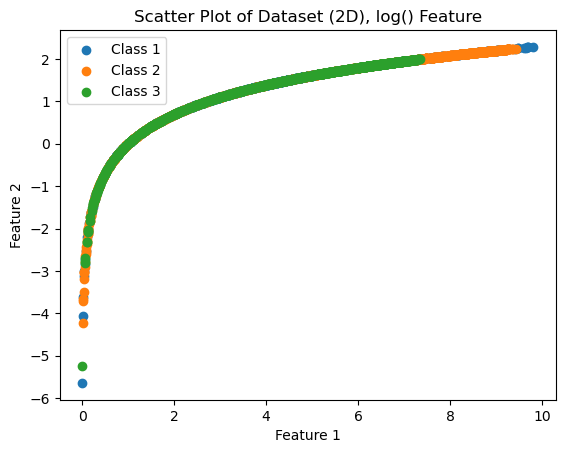

In [104]:
class1, class2, class3 = (
    df_train_transformed[df_train["class"] == 1][["x", "ln_y"]],
    df_train_transformed[df_train["class"] == 2][["x", "ln_y"]],
    df_train_transformed[df_train["class"] == 3][["x", "ln_y"]],
)

plt.scatter(class1["x"], class1["ln_y"], label='Class 1')
plt.scatter(class2["x"], class2["ln_y"], label='Class 2')
plt.scatter(class3["x"], class3["ln_y"], label='Class 3')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Dataset (2D), log() Feature")
plt.legend()
plt.show()

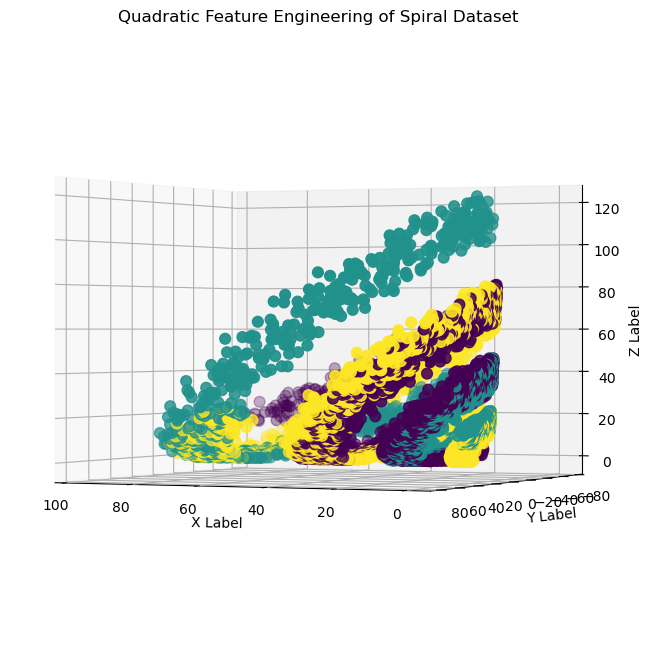

In [103]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(quadratic_X_train[:, 0],
           quadratic_X_train[:, 1],
           quadratic_X_train[:, 2],
           c=np.squeeze(df_train["class"].values), s=60)
ax.view_init(0, 115)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title("Quadratic Feature Engineering of Spiral Dataset")
plt.show()

### RBF

The quadratic mapping didn't seem to do much better. How about RBF?

I will be using the formulation of RBF kernel provided from [[1]](https://www.youtube.com/watch?v=Q0ExqOphnW0), found on YouTube.

In [83]:
def rbf_feature_mapping(x, y):
    rbf_feat = (
        -0.5 * (np.linalg(x - y) ** 2)
    )   
    trans_x = np.array([x, y, rbf_feat])				
    return trans_x

In [98]:
rbf_X_train = quadratic_feature_mapping(
    np.squeeze(X_train["x"].values),
    np.squeeze(X_train["y"].values),
)

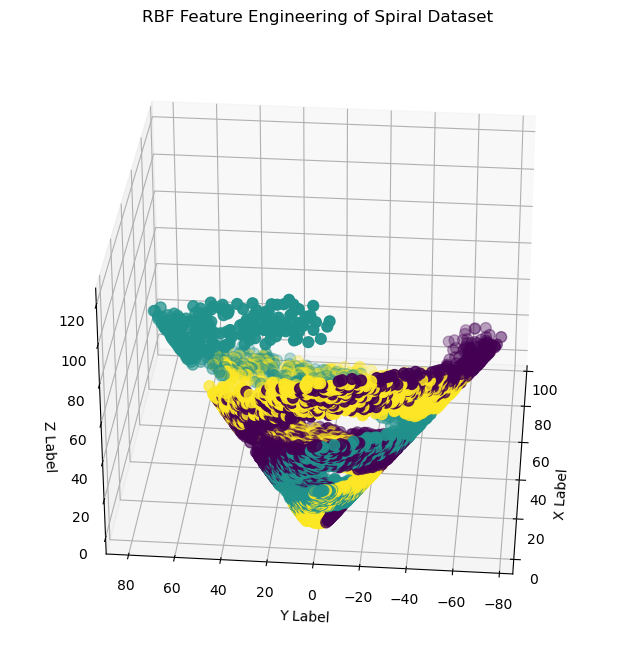

In [102]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rbf_X_train[0, :],
           rbf_X_train[1, :],
           rbf_X_train[2, :],
           c=np.squeeze(df_train["class"].values), s=60)
ax.view_init(30, 185)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title("RBF Feature Engineering of Spiral Dataset")
plt.show()